In [76]:
!pip install mujoco
!pip install mujoco-mjx
!pip install mediapy

In [77]:
import numpy as np

import jax
import mujoco
# from mujoco import mjx
import mediapy as media

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

""

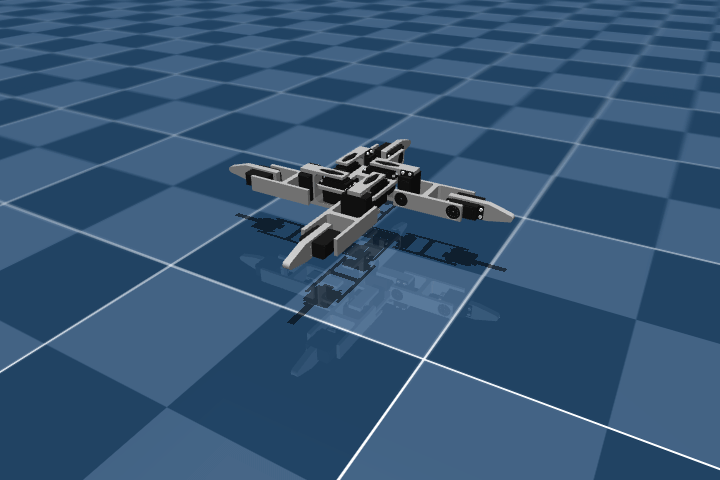

In [78]:
# Load model from file
model = mujoco.MjModel.from_xml_path("./models/quadruped/scene.xml")
data = mujoco.MjData(model)

duration = 3.8  # (seconds)
framerate = 60  # (Hz)
width, height = 720, 480  # Desired resolution

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model, width=width, height=height) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate, codec='gif')